#Object Localization

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-zkqfm3_a
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-zkqfm3_a
  Resolved https://github.com/albumentations-team/albumentations to commit c79683632e31a78c5c1c12881d323cd3e46a432a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
csv = "/content/object-localization-dataset/train.csv"
dataDir = "/content/object-localization-dataset/"

device = 'cuda'
batchSize  =16
imgSize = 140

LR = 0.001
epochs = 80
modelName = 'efficientnet_b0'

numCor = 4

In [6]:
df = pd.read_csv(csv)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


Training Data example

/content/object-localization-dataset/train_images/mushroom_20.jpg


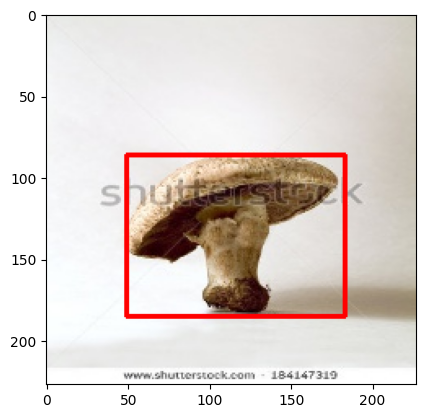

In [7]:
row = df.iloc[2]
# Print the image path to check for errors
print(dataDir + row.img_path)
img = cv2.imread(dataDir + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Showing bounding box
pt1 = (row.xmin, row.ymin)
p2 = (row.xmax, row.ymax)
bndBox = cv2.rectangle(img, pt1, p2, (255, 0, 0), 2)
plt.imshow(img)

In [8]:
trainDF,validDF = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
trainAugs = A.Compose([
    A.Resize(imgSize, imgSize),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

validAugs = A.Compose([
    A.Resize(imgSize, imgSize),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


#Custom Dataset

In [11]:
class ObjLocDatset(torch.utils.data.Dataset):
    def __init__(self, df, augs = None):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        bbox = [[xmin, ymin, xmax, ymax]]

        img = cv2.imread(dataDir + row.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augs:
            data = self.augs(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

        img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
        bbox = torch.tensor(bbox)
        return img, bbox

In [12]:
trainSet = ObjLocDatset(trainDF, trainAugs)
validSet = ObjLocDatset(validDF, validAugs)

In [13]:
print(f"Total examples in the trainset: {len(trainSet)}")
print(f"Total examples in the validset: {len(validSet)}")

Total examples in the trainset: 148
Total examples in the validset: 38


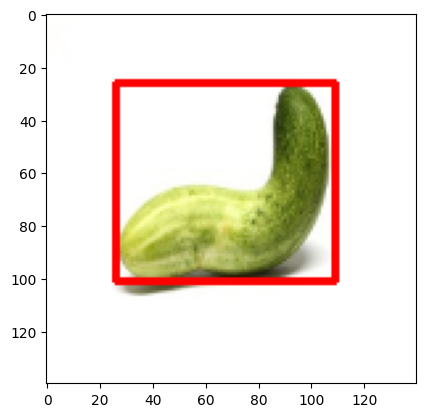

In [14]:
img, bbox = trainSet[34]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

#Loading dataset into batches

In [15]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True)
validLoader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=False)

In [16]:
print("Total no. batches in trainloader : {}".format(len(trainLoader)))
print("Total no. batches in validloader : {}".format(len(validLoader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images,bboxes in trainLoader:
    break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Creating the model

In [18]:
from torch import nn
import timm

In [19]:
class ObjLocModel(nn.Module):
    def __init__(self):
        super(ObjLocModel, self).__init__()
        self.backbone = timm.create_model(modelName, pretrained=True, num_classes=numCor)

    def forward(self, images,gt_bboxes=None):
        bboxes = self.backbone(images)
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
        return bboxes

In [20]:
model = ObjLocModel()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [21]:
randomImg = torch.rand(1,3,140,140).to(device)
model(randomImg).shape

torch.Size([1, 4])

#Creating Train and Eval Function

In [22]:
def trainFunc(model, dataLoader, optimizer):
    model.train()
    totalLoss = 0.0

    for data in tqdm(dataLoader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(device), gt_bboxes.to(device)

        bboxes, loss = model(images, gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalLoss += loss.item()

    return totalLoss / len(dataLoader)

In [23]:
def evalFunc(model, dataLoader, ):
    model.eval()
    totalLoss = 0.0

    with torch.no_grad():
      for data in tqdm(dataLoader):
          images, gt_bboxes = data
          images, gt_bboxes = images.to(device), gt_bboxes.to(device)

          bboxes, loss = model(images, gt_bboxes)
          totalLoss += loss.item()

      return totalLoss / len(dataLoader)

#Training Loop

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [25]:
bestValidLoss = np.inf

for i in range(epochs):
    trainLoss = trainFunc(model, trainLoader, optimizer)
    validLoss = evalFunc(model, validLoader)

    if validLoss < bestValidLoss:
      print("Valid Loss Improved from {} to {}".format(bestValidLoss, validLoss))
      bestValidLoss = validLoss
      torch.save(model.state_dict(), 'bestModel.pt')

    print(f"Epoch : {i+1} Train Loss : {trainLoss} Valid Loss : {validLoss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from inf to 7799.087890625
Epoch : 1 Train Loss : 5438.5759765625 Valid Loss : 7799.087890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 7799.087890625 to 2095.5247395833335
Epoch : 2 Train Loss : 2023.3788452148438 Valid Loss : 2095.5247395833335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 2095.5247395833335 to 268.36168416341144
Epoch : 3 Train Loss : 1247.796728515625 Valid Loss : 268.36168416341144


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 268.36168416341144 to 207.03775024414062
Epoch : 4 Train Loss : 758.224560546875 Valid Loss : 207.03775024414062


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 207.03775024414062 to 194.53936767578125
Epoch : 5 Train Loss : 604.5459167480469 Valid Loss : 194.53936767578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 434.83237915039064 Valid Loss : 221.3349609375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 346.3919479370117 Valid Loss : 219.9969228108724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 194.53936767578125 to 130.8863296508789
Epoch : 8 Train Loss : 255.74837265014648 Valid Loss : 130.8863296508789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 189.76120681762694 Valid Loss : 165.17852274576822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 141.59745025634766 Valid Loss : 151.60406239827475


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 130.8863296508789 to 121.25975545247395
Epoch : 11 Train Loss : 120.9344108581543 Valid Loss : 121.25975545247395


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 121.25975545247395 to 111.25143432617188
Epoch : 12 Train Loss : 96.77630043029785 Valid Loss : 111.25143432617188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 111.25143432617188 to 108.8832015991211
Epoch : 13 Train Loss : 111.25991592407226 Valid Loss : 108.8832015991211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 84.32862243652343 Valid Loss : 113.93681081136067


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 108.8832015991211 to 104.73206583658855
Epoch : 15 Train Loss : 77.09671783447266 Valid Loss : 104.73206583658855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 65.67804908752441 Valid Loss : 113.02759552001953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 104.73206583658855 to 84.37490336100261
Epoch : 17 Train Loss : 71.8147403717041 Valid Loss : 84.37490336100261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 84.37490336100261 to 81.34383392333984
Epoch : 18 Train Loss : 57.06680145263672 Valid Loss : 81.34383392333984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 81.34383392333984 to 57.06149546305338
Epoch : 19 Train Loss : 50.70640830993652 Valid Loss : 57.06149546305338


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 42.81354179382324 Valid Loss : 73.33566284179688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 61.04461479187012 Valid Loss : 85.0250244140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 44.8992374420166 Valid Loss : 64.30477523803711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 57.06149546305338 to 49.74193572998047
Epoch : 23 Train Loss : 45.02595882415771 Valid Loss : 49.74193572998047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 55.379387283325194 Valid Loss : 60.82687505086263


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 42.40683727264404 Valid Loss : 49.99281597137451


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 Train Loss : 39.6642972946167 Valid Loss : 70.8232027689616


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 47.701633834838866 Valid Loss : 60.8562068939209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 41.73205451965332 Valid Loss : 68.26797739664714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 49.74193572998047 to 48.81687545776367
Epoch : 29 Train Loss : 41.19581985473633 Valid Loss : 48.81687545776367


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 Train Loss : 37.655202865600586 Valid Loss : 64.87652079264323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 30.640387630462648 Valid Loss : 52.484381993611656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 37.85543975830078 Valid Loss : 50.716723124186196


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 Train Loss : 25.428697395324708 Valid Loss : 61.738197326660156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 29.835401439666747 Valid Loss : 71.60650698343913


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 30.35701208114624 Valid Loss : 64.80772654215495


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 36.097580909729004 Valid Loss : 56.84697596232096


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 48.81687545776367 to 45.83176040649414
Epoch : 37 Train Loss : 38.173129653930665 Valid Loss : 45.83176040649414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 Train Loss : 29.0327428817749 Valid Loss : 58.24078623453776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 45.83176040649414 to 42.21824264526367
Epoch : 39 Train Loss : 31.73790760040283 Valid Loss : 42.21824264526367


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 36.77368049621582 Valid Loss : 52.93048604329427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 42.21824264526367 to 40.57255013783773
Epoch : 41 Train Loss : 27.343184375762938 Valid Loss : 40.57255013783773


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 42 Train Loss : 31.490442276000977 Valid Loss : 51.24425379435221


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 43 Train Loss : 42.99016237258911 Valid Loss : 51.049461364746094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 44 Train Loss : 27.377843284606932 Valid Loss : 47.664669036865234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 45 Train Loss : 31.302875518798828 Valid Loss : 44.0617790222168


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 46 Train Loss : 27.136799812316895 Valid Loss : 49.06105168660482


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 47 Train Loss : 26.86490478515625 Valid Loss : 55.55241139729818


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 48 Train Loss : 24.46285209655762 Valid Loss : 49.16418139139811


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 49 Train Loss : 29.187189674377443 Valid Loss : 50.718430836995445


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 40.57255013783773 to 39.86835034688314
Epoch : 50 Train Loss : 34.98869609832764 Valid Loss : 39.86835034688314


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 51 Train Loss : 27.103507804870606 Valid Loss : 50.81617863972982


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 52 Train Loss : 30.46032600402832 Valid Loss : 43.583910624186196


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 53 Train Loss : 37.277764892578126 Valid Loss : 52.03908920288086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 54 Train Loss : 33.21090211868286 Valid Loss : 41.42003313700358


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 55 Train Loss : 38.19379234313965 Valid Loss : 50.36724980672201


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 39.86835034688314 to 39.28949991861979
Epoch : 56 Train Loss : 34.983377838134764 Valid Loss : 39.28949991861979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 57 Train Loss : 32.38103990554809 Valid Loss : 45.31994501749674


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 58 Train Loss : 30.233760261535643 Valid Loss : 46.44138209025065


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 59 Train Loss : 36.03227081298828 Valid Loss : 43.22599983215332


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 60 Train Loss : 33.799198913574216 Valid Loss : 55.233011881510414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 61 Train Loss : 24.554777240753175 Valid Loss : 56.0582275390625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 62 Train Loss : 28.574440574645998 Valid Loss : 43.66404596964518


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 63 Train Loss : 20.87186269760132 Valid Loss : 51.02991326649984


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 64 Train Loss : 19.920271015167238 Valid Loss : 59.6663761138916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 65 Train Loss : 23.183879566192626 Valid Loss : 46.22326850891113


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 66 Train Loss : 20.448630142211915 Valid Loss : 41.54099210103353


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 67 Train Loss : 26.70947027206421 Valid Loss : 46.784629821777344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 68 Train Loss : 27.809261512756347 Valid Loss : 45.87215042114258


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 69 Train Loss : 23.456573009490967 Valid Loss : 40.019227027893066


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 70 Train Loss : 23.690991115570068 Valid Loss : 49.30982335408529


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 71 Train Loss : 26.86658763885498 Valid Loss : 48.13589731852213


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 72 Train Loss : 25.558801651000977 Valid Loss : 46.88115247090658


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 73 Train Loss : 18.358552932739258 Valid Loss : 44.45582580566406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 74 Train Loss : 23.772239017486573 Valid Loss : 48.90848159790039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 75 Train Loss : 28.321099758148193 Valid Loss : 50.73335965474447


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 76 Train Loss : 23.067115592956544 Valid Loss : 52.32064437866211


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 77 Train Loss : 22.806606435775755 Valid Loss : 49.93712361653646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 78 Train Loss : 22.870716381073 Valid Loss : 43.13451957702637


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Valid Loss Improved from 39.28949991861979 to 36.86292584737142
Epoch : 79 Train Loss : 52.79588098526001 Valid Loss : 36.86292584737142


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 80 Train Loss : 26.561900234222414 Valid Loss : 41.65556208292643


#Inference

In [26]:
import utils

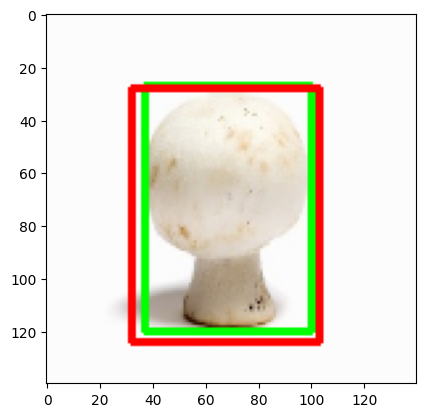

In [27]:
model.load_state_dict(torch.load('bestModel.pt'))
model.eval()

#Example
with torch.no_grad():
    image, gt_bbox = validSet[34]
    image = image.unsqueeze(0).to(device)
    outBbox = model(image)

    utils.compare_plots(image, gt_bbox, outBbox)

In [49]:
#Calculating Intersection over Union predicted and Ground Truth bounding boxes
def iou_metric(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    IOU = interArea / float(boxAArea + boxBArea - interArea)
    return IOU

In [47]:
predictedBoxes_xyxy = []
groundTruthBoxes_xyxy = []
for i in range(len(validSet)):

    img, gt_bbox = validSet[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_bbox = model(img)

    pred_bbox = pred_bbox[0].cpu().numpy()

    predictedBoxes_xyxy.append(
        (float(pred_bbox[0]), float(pred_bbox[1]), float(pred_bbox[2]), float(pred_bbox[3]))
    )
    groundTruthBoxes_xyxy.append(
        (float(gt_bbox[0]), float(gt_bbox[1]), float(gt_bbox[2]), float(gt_bbox[3]))
    )

IOUs = []
for pred_box, gt_box in zip(predictedBoxes_xyxy, groundTruthBoxes_xyxy):
    if pred_box is None or gt_box is None:
        continue

    iouVal = iou_metric(pred_box, gt_box)
    IOUs.append(iouVal)

avgIOU = sum(IOUs) / len(IOUs) if IOUs else 0
print(f"Average IoU across images: {avgIOU:.3f}")

Average IoU across images: 0.810
